In [1]:
# import sys

# from pathlib import Path

# !{sys.executable} -m pip install -e {Path.cwd().parent}
# !{sys.executable} -m pip install datashader matplotlib seaborn tifffile
# !{sys.executable} -m pip install "napari[all]"

In [2]:
import colorcet as cc
import datashader as ds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datashader.mpl_ext import dsshow
from scipy.stats import norm
from skimage import measure, morphology
from tifffile import imread

from simutome.estim import CellSlicer

# Parameter estimation from 3D volume

## Image loading

In [3]:
img_file = "../data/datasets/kuett_catena_2021/main_her2_brca_model/img.tiff"
mask_file = "../data/datasets/kuett_catena_2021/main_her2_brca_model/mask.tiff"
panel_file = "../data/datasets/kuett_catena_2021/main_her2_brca_model/panel.csv"
channel_name_col = "name"
channel_label_col = "label"
voxel_size_um = (2.0, 1.0, 1.0)
erosion_footprint = morphology.disk(1.0)[None, :, :]  # None
sectioning_axes = [2, 1, 0]
section_thicknesses_um = [2.0, 4.0, 6.0, 8.0, 10.0]
min_proj_cell_slice_area_um2 = 5.0

In [4]:
# load image
img = imread(img_file).astype(np.float32)
assert img.ndim == 4
print(f"Loaded image with shape {img.shape}")

# load mask
mask = imread(mask_file).astype(np.uint32)
assert mask.ndim == 3
assert mask.shape[0] == img.shape[0]
assert mask.shape[1:] == img.shape[2:]
print(f"Loaded mask with shape {mask.shape} containing {np.unique(mask).size - 1} labels")

# erode previously dilated pixels to correct for axis inconsistencies
if erosion_footprint is not None:
    mask *= morphology.binary_erosion(mask != 0, erosion_footprint)
    print(f"Eroded mask, now containing {np.unique(mask).size - 1} labels")

# # relabel mask to avoid duplicated cell IDs (was needed for the mask saved as uint16)
# mask, num_cells = measure.label(mask, return_num=True)
# print(f"Relabeled mask containing {num_cells} cells")

# remove border cells to avoid biases
border_cells = np.unique(
    np.concatenate(
        (
            np.unique(mask[[0, -1], :, :]),
            np.unique(mask[:, [0, -1], :]),
            np.unique(mask[:, :, [0, -1]]),
        )
    )
)
mask[np.isin(mask, border_cells)] = 0
num_cells = np.unique(mask).size - 1
print(f"Dropped {len(border_cells) - 1} border cells, now containing {num_cells} cells")

# crop image & mask to speed up computation
ix = np.flatnonzero(np.amax(mask, axis=(0, 1)) != 0)
iy = np.flatnonzero(np.amax(mask, axis=(0, 2)) != 0)
iz = np.flatnonzero(np.amax(mask, axis=(1, 2)) != 0)
img = img[:, :, :, np.amin(ix):np.amax(ix) + 1]
img = img[:, :, np.amin(iy):np.amax(iy) + 1, :]
img = img[np.amin(iz):np.amax(iz) + 1, :, :, :]
mask = mask[:, :, np.amin(ix):np.amax(ix) + 1]
mask = mask[:, np.amin(iy):np.amax(iy) + 1, :]
mask = mask[np.amin(iz):np.amax(iz) + 1, :, :]
print(f"Cropped image and mask to shape {mask.shape}")

# load panel
panel = pd.read_csv(panel_file)
assert len(panel.index) == img.shape[1]
channel_names = panel[channel_name_col].tolist()
channel_labels = panel[channel_label_col].tolist()
print("Channels:")
for i, (channel_name, channel_label) in enumerate(zip(channel_names, channel_labels)):
    print(f"  {i:2d}  {channel_name.ljust(max(len(x) for x in channel_names))}  {channel_label}")
    
cell_slicer = CellSlicer(mask, intensities=img, channel_names=channel_names, voxel_size_um=voxel_size_um)

Loaded image with shape (152, 27, 488, 652)
Loaded mask with shape (152, 488, 652) containing 108486 labels
Eroded mask, now containing 108484 labels
Dropped 9319 border cells, now containing 99165 cells
Cropped image and mask to shape (150, 486, 650)
Channels:
   0  HH3          Histone H3
   1  CK5          Cytokeratin 5
   2  CK19         Cytokeratin 19
   3  CK8/18       Cytokeratin 8/18
   4  CD68         CD68
   5  KRT14        Keratin 14
   6  SMA          SMA
   7  Vimentin     Vimentin
   8  CD138        CD138 (syndecan-1)
   9  CD3e         CD3 epsilon
  10  pHH3         phospho-Histone H3
  11  HER2         c-erbB-2 (HER2)
  12  CD44         CD44
  13  MPO          Myeloperoxidase (MPO)
  14  CD45         CD45
  15  CD20         CD20
  16  CD8a         CD8a
  17  COL1         Collagen I
  18  Ki-67        Ki-67
  19  pS6          phospho-S6
  20  VWF+CD31     VWF + CD31
  21  E/P-Cad      E/P-Cadherin
  22  CK7          Cytokeratin 7
  23  panCK        pan-Cytokeratin
  24  

In [5]:
# import napari
#
# viewer = napari.Viewer()
# viewer.add_image(
#     img[:, ::-1, :, :],
#     channel_axis=1,
#     colormap="gray", 
#     name=channel_names[::-1],
#     scale=voxel_size_um, 
#     visible=False,
# );
# viewer.add_labels(
#     mask,
#     name="Cell mask",
#     scale=voxel_size_um,
#     visible=False,
# );

## Cell measurement

In [6]:
cell_data_file = "../data/temp/parameter_estimation/cell_data.csv"

cell_data = cell_slicer.measure_cells(sectioning_axes, progress=True)
cell_data.insert(1, "sectioning_axis_name", np.array(["z", "y", "x"])[cell_data["sectioning_axis"].values])
cell_data["cell_radius_um"] = (0.75 * cell_data["cell_volume_um3"] / np.pi) ** (1 / 3)
cell_data["proj_cell_radius_um"] = (cell_data["proj_cell_area_um2"] / np.pi) ** 0.5
cell_data.to_csv(cell_data_file, index=False)

# cell_data = pd.read_csv(cell_data_file)

cell_data

  0%|          | 0/297495 [00:00<?, ?it/s]

,sectioning_axis,sectioning_axis_name,cell_id,cell_volume_um3,cell_centroid_x_um,cell_centroid_y_um,cell_centroid_z_um,proj_cell_area_um2,proj_cell_centroid_x_um,proj_cell_centroid_y_um,...,mean_proj_cell_intensity_pS6,mean_proj_cell_intensity_VWF+CD31,mean_proj_cell_intensity_E/P-Cad,mean_proj_cell_intensity_CK7,mean_proj_cell_intensity_panCK,mean_proj_cell_intensity_cPARP/Casp3,mean_proj_cell_intensity_DNA1,mean_proj_cell_intensity_DNA2,cell_radius_um,proj_cell_radius_um
0,2,x,3462,22.0,524.000000,416.000000,298.000000,10.0,NaN,2.000000,...,0.000000,0.800000,1.000000,0.000000,1.200000,0.000000,9.800000,16.000000,1.738246,1.784124
1,2,x,3607,32.0,491.000000,247.625000,298.000000,8.0,NaN,1.500000,...,0.250000,1.250000,14.000000,4.250000,178.000000,1.750000,35.500000,65.250000,1.969490,1.595769
2,2,x,4072,128.0,83.984375,475.546875,297.250000,30.0,NaN,5.000000,...,5.333333,2.733333,6.533333,0.333333,3.333333,0.666667,59.466667,113.133331,3.126371,3.090194
3,2,x,4086,62.0,521.645161,462.258065,298.000000,20.0,NaN,4.500000,...,0.300000,0.400000,3.200000,0.000000,12.100000,0.500000,25.900000,48.299999,2.455280,2.523133
4,2,x,4088,48.0,484.041667,458.291667,298.000000,12.0,NaN,2.500000,...,0.333333,1.666667,7.500000,0.166667,0.500000,1.166667,30.666666,61.166668,2.254503,1.954410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297490,0,z,248016,100.0,58.680000,20.180000,0.560000,36.0,3.861111,2.555556,...,0.027778,0.444444,1.805556,0.111111,26.861111,0.472222,7.555555,14.111111,2.879412,3.385138
297491,0,z,248017,82.0,68.146341,19.073171,0.585366,30.0,2.200000,3.100000,...,0.100000,0.300000,1.800000,0.200000,17.000000,0.266667,6.733333,14.533334,2.695101,3.090194
297492,0,z,248019,52.0,588.884615,22.000000,0.000000,26.0,1.884615,3.000000,...,0.038462,0.615385,1.576923,0.038462,5.230769,0.653846,8.923077,16.384615,2.315465,2.876814
297493,0,z,248026,42.0,454.285714,12.142857,0.000000,21.0,2.285714,3.142857,...,0.190476,0.523810,6.952381,0.714286,31.333334,0.523810,15.047619,30.380953,2.156355,2.585441


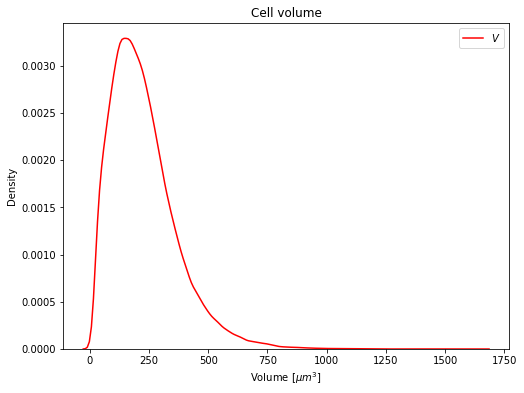

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    data=cell_data.groupby("cell_id")[["cell_volume_um3"]].mean(),
    x="cell_volume_um3",
    ax=ax,
    color="red",
)
ax.set_title("Cell volume")
ax.set_xlabel(r"Volume [$\mu m^3$]")
ax.set_ylabel("Density")
ax.legend([r"$V$"])

plt.show()

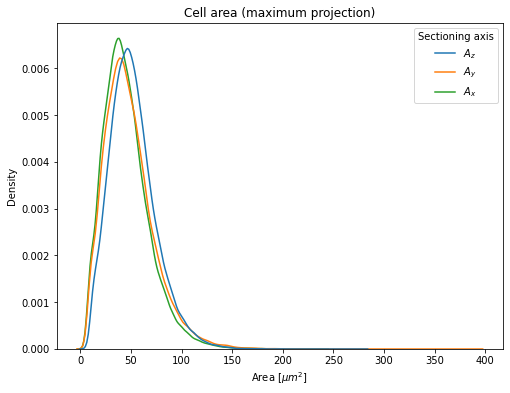

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.kdeplot(
    data=cell_data,
    x="proj_cell_area_um2",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    ax=ax,
)
p.legend_.set_title("Sectioning axis")
for text, label in zip(p.legend_.texts, [ r"$A_z$", r"$A_y$", r"$A_x$"]):
    text.set_text(label)
ax.set_title("Cell area (maximum projection)")
ax.set_xlabel(r"Area [$\mu m^2$]")
ax.set_ylabel("Density")

plt.show()

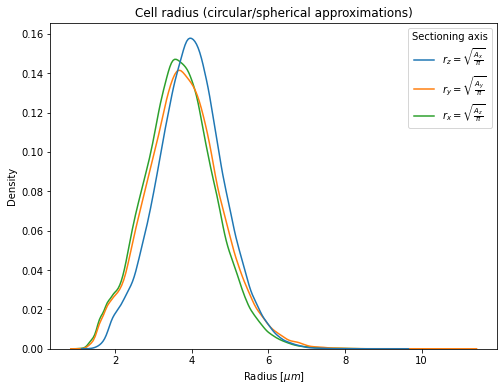

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.kdeplot(
    data=cell_data,
    x="proj_cell_radius_um",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    ax=ax,
)
p.legend_.set_title("Sectioning axis")
for text, label in zip(
    p.legend_.texts,
    [
        r"$r_z = \sqrt{\frac{A_x}{\pi}}$",
        r"$r_y = \sqrt{\frac{A_y}{\pi}}$",
        r"$r_x = \sqrt{\frac{A_z}{\pi}}$",
        r"$r = \sqrt[3]{\frac{3 V}{4 \pi}}$",
    ],
):
    text.set_text(label)
ax.set_title("Cell radius (circular/spherical approximations)")
ax.set_xlabel(r"Radius [$\mu m$]")
ax.set_ylabel("Density")

plt.show()

## In-silico cell sectioning

In [10]:
cell_slice_data_file = "../data/temp/parameter_estimation/cell_slice_data.csv"

for i, sectioning_axis in enumerate(sectioning_axes):    
    cell_slice_data = cell_slicer.measure_cell_slices([sectioning_axis], section_thicknesses_um, progress=True)
    cell_slice_data = cell_slice_data[cell_slice_data["proj_cell_slice_area_um2"] >= min_proj_cell_slice_area_um2]
    cell_slice_data.insert(1, "sectioning_axis_name", np.array(["z", "y", "x"])[cell_slice_data["sectioning_axis"].values])
    cell_slice_data["cell_slice_radius_um"] = (0.75 * cell_slice_data["cell_slice_volume_um3"] / np.pi) ** (1.0 / 3.0)
    cell_slice_data["proj_cell_slice_radius_um"] = (cell_slice_data["proj_cell_slice_area_um2"] / np.pi) ** 0.5
    cell_slice_data.to_csv(cell_slice_data_file, header=(i == 0), index=False, mode=("w" if i == 0 else "a"))
cell_slice_data = pd.read_csv(cell_slice_data_file)

# cell_slice_data = pd.read_csv(cell_slice_data_file)

cell_slice_data

  0%|          | 0/1615 [00:00<?, ?it/s]

  0%|          | 0/1205 [00:00<?, ?it/s]

  0%|          | 0/740 [00:00<?, ?it/s]

,sectioning_axis,sectioning_axis_name,section_thickness_um,section_offset_um,cell_id,cell_slice_number,cell_slice_volume_um3,cell_slice_centroid_x_um,cell_slice_centroid_y_um,cell_slice_centroid_z_um,...,mean_proj_cell_slice_intensity_pS6,mean_proj_cell_slice_intensity_VWF+CD31,mean_proj_cell_slice_intensity_E/P-Cad,mean_proj_cell_slice_intensity_CK7,mean_proj_cell_slice_intensity_panCK,mean_proj_cell_slice_intensity_cPARP/Casp3,mean_proj_cell_slice_intensity_DNA1,mean_proj_cell_slice_intensity_DNA2,cell_slice_radius_um,proj_cell_slice_radius_um
0,2,x,2.0,0.0,5623,0,14.0,0.714286,364.857143,296.000000,...,1.400000,1.200000,2.400000,0.000000,0.000000,0.800000,11.600000,16.799999,1.495133,1.784124
1,2,x,2.0,0.0,6672,0,16.0,0.750000,436.875000,295.250000,...,0.333333,0.166667,0.333333,0.000000,0.000000,0.000000,16.500000,30.333334,1.563185,1.954410
2,2,x,2.0,0.0,8737,0,22.0,0.818182,237.181818,295.090909,...,1.222222,0.666667,3.000000,0.444444,21.111111,0.333333,5.000000,12.111111,1.738246,2.393654
3,2,x,2.0,0.0,11552,0,8.0,1.000000,295.500000,292.000000,...,0.000000,0.000000,0.250000,0.000000,0.000000,0.500000,4.750000,8.750000,1.240701,1.595769
4,2,x,2.0,0.0,15594,0,20.0,1.000000,11.900000,287.200000,...,0.100000,0.300000,1.200000,0.200000,0.500000,0.500000,8.200000,16.900000,1.683890,2.523133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003015,0,z,10.0,8.0,20358,2,20.0,48.500000,161.000000,288.000000,...,0.800000,0.200000,5.200000,0.300000,16.799999,0.800000,0.400000,0.800000,1.683890,1.784124
9003016,0,z,10.0,8.0,20492,2,48.0,43.458333,47.541667,288.416667,...,0.000000,0.315789,0.578947,0.157895,2.052632,0.210526,8.052631,13.526316,2.254503,2.459245
9003017,0,z,10.0,8.0,21155,2,10.0,283.800000,136.400000,288.000000,...,0.000000,0.200000,4.800000,0.200000,16.200001,1.200000,6.200000,10.800000,1.336505,1.261566
9003018,0,z,10.0,8.0,21653,2,28.0,615.785714,363.357143,288.000000,...,0.642857,0.142857,0.214286,0.000000,0.428571,0.000000,4.642857,8.071428,1.883749,2.111004


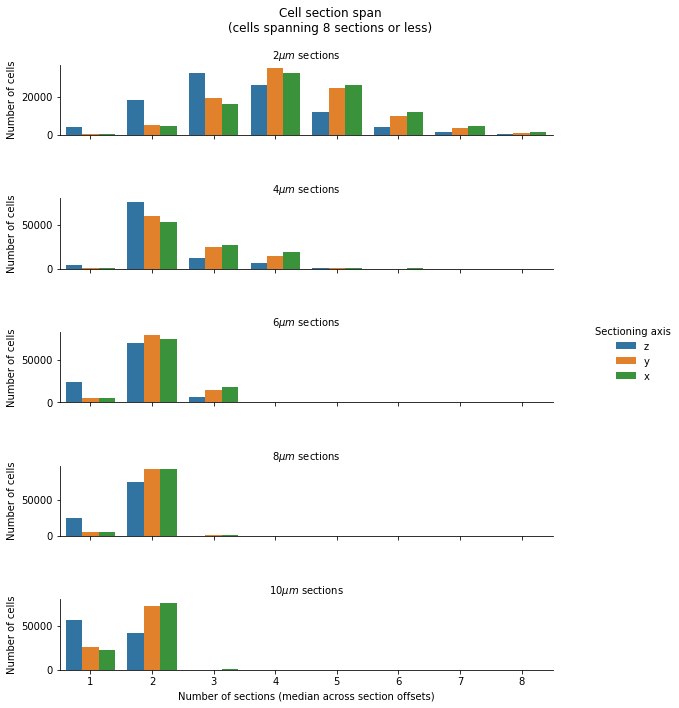

In [11]:
g = sns.catplot(
    data=cell_slice_data.groupby(
        ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]
    ).size().reset_index(name="cell_section_span").groupby(
        ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "cell_id"]
    )["cell_section_span"].median().round().astype(int).reset_index(name="cell_section_span"),
    x="cell_section_span",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    row="section_thickness_um",
    kind="count",
    height=2,
    aspect=8 / 2,
    sharey=False,
)
g.legend.set_title("Sectioning axis")
g.set_titles(row_template=r"${row_name:g} \mu m$ sections")
g.set(
    xlim=(-0.5, 7.5),
    xlabel="Number of sections (median across section offsets)",
    ylabel="Number of cells",
)
g.fig.suptitle("Cell section span\n(cells spanning 8 sections or less)")
g.fig.subplots_adjust(hspace=0.9, top=0.9)

plt.show()

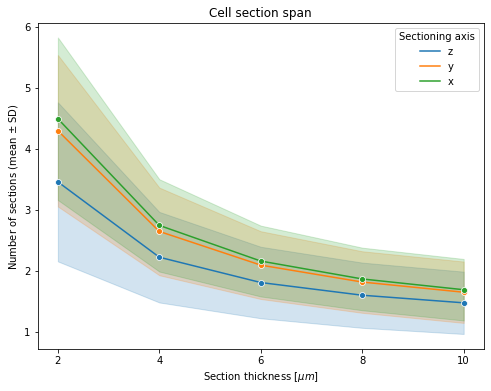

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.lineplot(
    data=cell_slice_data.groupby(
        ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]
    ).size().reset_index(name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    marker="o",
    ci="sd",
    ax=ax,
)
p.legend_.set_title("Sectioning axis")
ax.set_title("Cell section span")
ax.set_xlabel(r"Section thickness [$\mu m$]")
ax.set_ylabel(r"Number of sections (mean $\pm$ SD)")
ax.set_xticks(cell_slice_data["section_thickness_um"].unique())

plt.show()

## Parameter estimation

### Cell exclusion

In [13]:
rng = np.random.default_rng(seed=123)
df = cell_data[cell_data["sectioning_axis_name"] == "z"]

mu_r = df["proj_cell_radius_um"].mean()
sigma_r = df["proj_cell_radius_um"].std()
x_r = np.linspace(df["proj_cell_radius_um"].min(), df["proj_cell_radius_um"].max(), 1000)
y_r = norm.pdf(x_r, mu_r, sigma_r)

t = cell_slice_data["section_thickness_um"].unique()
r = rng.normal(loc=mu_r, scale=sigma_r, size=len(cell_data.index))
s = np.ceil(2 * r[:, None] / t[None, :])

def s_dash(k):
    n1 = np.floor((t[None, :] - ((2 * r[:, None]) % t[None, :])) / k) + 1
    n2 = np.ceil(((2 * r[:, None]) % t[None, :]) / k) - 1
    return (n1 * s + (n2 * (s + 1))) / (n1 + n2)

s_dash_k0 = s_dash(1e-12)
p_exclude = 1 / s_dash_k0

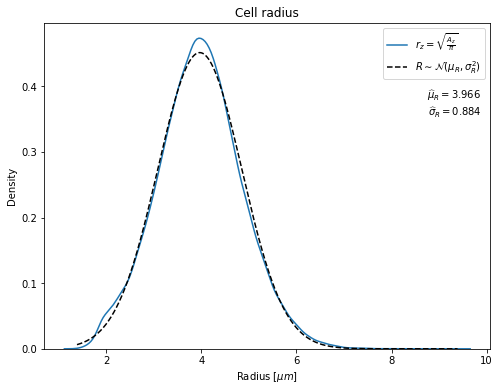

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    data=cell_data[cell_data["sectioning_axis_name"] == "z"],
    x="proj_cell_radius_um",
    label=r"$r_z = \sqrt{\frac{A_z}{\pi}}$",
    ax=ax,
)
ax.plot(
    x_r,
    y_r,
    label=r"$R \sim \mathcal{N}(\mu_R, \sigma_R^2)$",
    color="black",
    ls="--",
)
ax.text(
    0.98,
    0.8,
    f"$\\widehat{{\\mu}}_R = {mu_r:.3f}$\n$\\widehat{{\\sigma}}_R = {sigma_r:.3f}$",
    transform=ax.transAxes,
    ha="right",
    va="top",
)
ax.set_title("Cell radius")
ax.set_xlabel(r"Radius [$\mu m$]")
ax.set_ylabel("Density")
ax.legend()

plt.show()

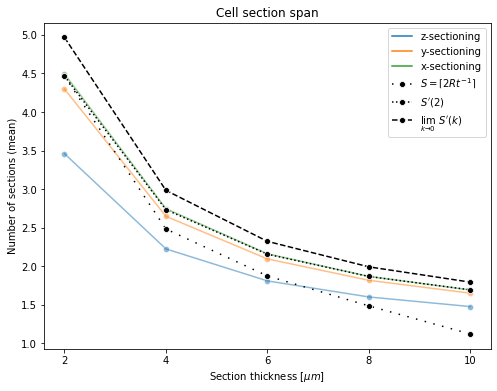

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.lineplot(
    data=cell_slice_data.groupby(
        ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]
    ).size().reset_index(name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    hue="sectioning_axis_name",
    hue_order=["z", "y", "x"],
    marker="o",
    ci=None,
    ax=ax,
    alpha=0.5,
)
p = sns.lineplot(
    data=pd.DataFrame(data=s, columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    marker="o",
    ci=None,
    ax=ax,
    color="black",
    ls=(0, (1, 5)),
    label=r"$S = \lceil 2 R t^{-1} \rceil$",
)
p = sns.lineplot(
    data=pd.DataFrame(data=s_dash(np.amax(voxel_size_um)), columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    marker="o",
    ci=None,
    ax=ax,
    color="black",
    ls=":",
    label=f"$S'({np.amax(voxel_size_um):g})$",
)
p = sns.lineplot(
    data=pd.DataFrame(data=s_dash_k0, columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
    x="section_thickness_um",
    y="cell_section_span",
    marker="o",
    ci=None,
    ax=ax,
    color="black",
    ls="--",
    label=r"$\lim_{k \to 0}~S'(k)$",
)
for text, label in zip(p.legend_.texts[:3], ["z-sectioning", "y-sectioning", "x-sectioning"]):
    text.set_text(label)
ax.set_title("Cell section span")
ax.set_xlabel(r"Section thickness [$\mu m$]")
ax.set_ylabel(r"Number of sections (mean)")
ax.set_xticks(cell_slice_data["section_thickness_um"].unique())

plt.show()

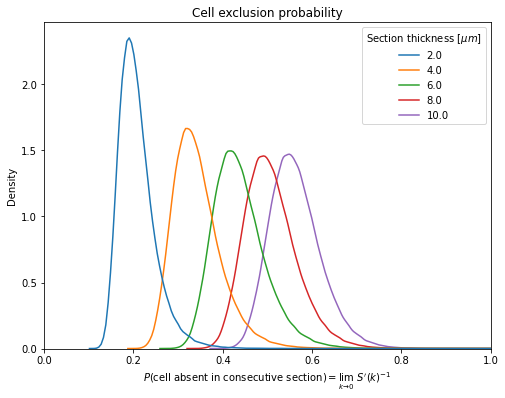

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

df = pd.DataFrame(data=p_exclude, columns=t).melt(var_name="section_thickness_um", value_name="cell_exclusion_probab")
df["section_thickness_um"] = df["section_thickness_um"].astype("category")

p = sns.kdeplot(
    data=df,
    x="cell_exclusion_probab",
    hue="section_thickness_um",
    hue_order=t,
    ax=ax,
)
p.legend_.set_title(r"Section thickness [$\mu m$]")
ax.set_title(f"Cell exclusion probability")
ax.set_xlabel(r"$P($cell absent in consecutive section$) = \lim_{k \to 0}~S'(k)^{-1}$")
ax.set_ylabel(r"Density")
ax.set_xlim(0, 1)

plt.show()

### Cell displacement

In [17]:
cell_slice_displacement_data_file = "../data/temp/parameter_estimation/cell_slice_displacement_data.csv"

cell_index_cols = ["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id"]
cell_slice_centroid_cols = ["cell_slice_centroid_x_um", "cell_slice_centroid_y_um", "cell_slice_centroid_z_um"]
proj_cell_slice_centroid_cols = ["proj_cell_slice_centroid_x_um", "proj_cell_slice_centroid_y_um", "proj_cell_slice_centroid_z_um"]
cell_slice_centroid_displacement_cols = ["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um", "cell_slice_centroid_displacement_z_um"]
proj_cell_slice_centroid_displacement_cols = ["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um", "proj_cell_slice_centroid_displacement_z_um"]
cell_slice_displacement_data = cell_slice_data.set_index(cell_index_cols +  ["cell_slice_number"]).sort_index()
cell_slice_displacement_data = cell_slice_displacement_data[cell_slice_centroid_cols + proj_cell_slice_centroid_cols]
cell_slice_displacement_data = cell_slice_displacement_data - cell_slice_displacement_data.groupby(cell_index_cols, sort=False).shift()
cell_slice_displacement_data.rename(columns=dict(zip(cell_slice_centroid_cols, cell_slice_centroid_displacement_cols)), inplace=True)
cell_slice_displacement_data.rename(columns=dict(zip(proj_cell_slice_centroid_cols, proj_cell_slice_centroid_displacement_cols)), inplace=True)
cell_slice_displacement_data.dropna(inplace=True, subset=cell_slice_centroid_displacement_cols)
cell_slice_displacement_data.reset_index(inplace=True)
cell_slice_displacement_data.to_csv(cell_slice_displacement_data_file, index=False)

# cell_slice_displacement_data = pd.read_csv(cell_slice_displacement_data_file)

cell_slice_displacement_data

,sectioning_axis,sectioning_axis_name,section_thickness_um,section_offset_um,cell_id,cell_slice_number,cell_slice_centroid_displacement_x_um,cell_slice_centroid_displacement_y_um,cell_slice_centroid_displacement_z_um,proj_cell_slice_centroid_displacement_x_um,proj_cell_slice_centroid_displacement_y_um,proj_cell_slice_centroid_displacement_z_um
0,0,z,2.0,0.0,4072,1,-0.491667,-0.391667,2.000000,0.508333,3.608333,NaN
1,0,z,2.0,0.0,4091,2,-1.130000,-2.850000,2.000000,1.870000,2.150000,NaN
2,0,z,2.0,0.0,4104,1,0.100000,0.533333,2.000000,1.100000,1.533333,NaN
3,0,z,2.0,0.0,4171,1,-0.220238,0.470238,2.000000,-0.220238,0.470238,NaN
4,0,z,2.0,0.0,4179,1,1.266667,0.255556,2.000000,1.266667,1.255556,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4548609,2,x,10.0,8.0,248006,1,3.370370,-1.240741,0.000000,NaN,-1.000000,0.000000
4548610,2,x,10.0,8.0,248016,1,3.389706,0.908088,-0.095588,NaN,0.375000,-0.083333
4548611,2,x,10.0,8.0,248017,1,2.283069,-0.431217,-0.195767,NaN,0.666667,-0.066667
4548612,2,x,10.0,8.0,248019,1,2.227273,0.590909,0.000000,NaN,1.500000,0.000000


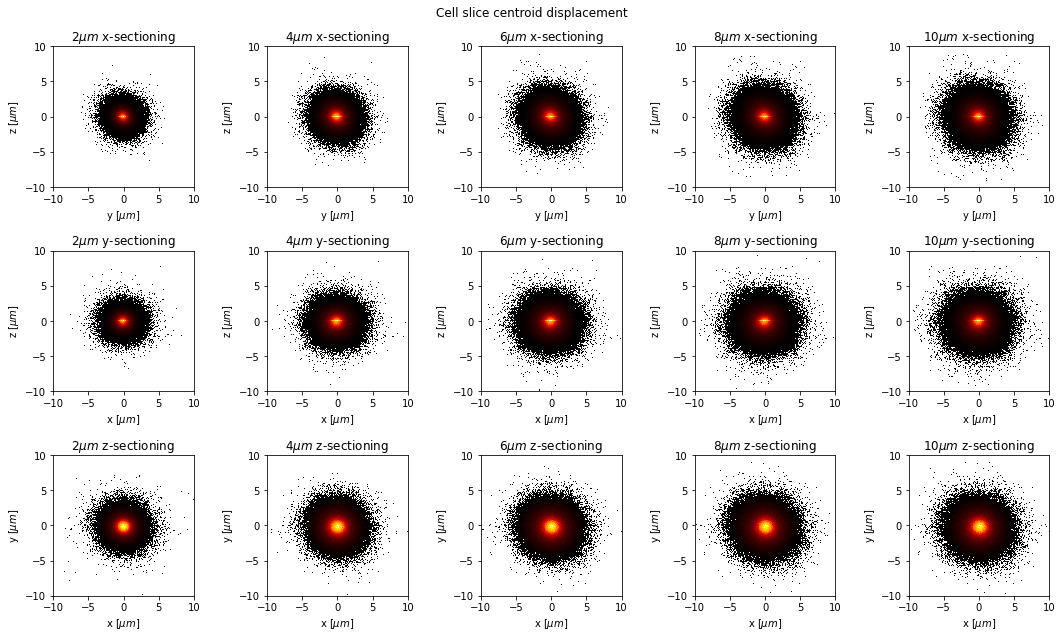

In [18]:
sectioning_axis_names = ("x", "y", "z")
fig, axes = plt.subplots(nrows=3, ncols=cell_slice_displacement_data["section_thickness_um"].nunique(), figsize=(15, 9))
for (i, row_axes), sectioning_axis_name in zip(enumerate(axes), sectioning_axis_names):
    x, y = tuple(a for a in sectioning_axis_names if a != sectioning_axis_name)
    df = cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == sectioning_axis_name]
    for (j, ax), (section_thickness_um, g) in zip(enumerate(row_axes), df.groupby("section_thickness_um")):
        dsshow(g, ds.Point(f"cell_slice_centroid_displacement_{x}_um", f"cell_slice_centroid_displacement_{y}_um"), cmap=cc.fire, ax=ax)
        ax.set_title(f"${section_thickness_um:g} \\mu m$ {sectioning_axis_name}-sectioning")
        ax.set_xlabel(f"{x} [$\\mu m$]")
        ax.set_ylabel(f"{y} [$\\mu m$]")
        ax.set_ylim(-10, 10)
        ax.set_xlim(-10, 10)
plt.suptitle("Cell slice centroid displacement")
plt.tight_layout()
plt.show()

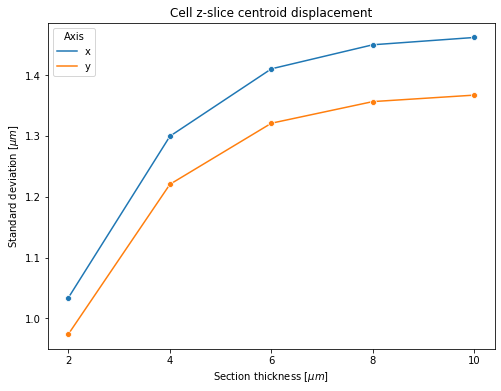

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.lineplot(
    data=cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].melt(
        id_vars=["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id", "cell_slice_number"],
        value_vars=["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um"],
        var_name="cell_slice_centroid_displacement_column",
        value_name="cell_slice_centroid_displacement_um",
    ),
    x="section_thickness_um",
    y="cell_slice_centroid_displacement_um",
    hue="cell_slice_centroid_displacement_column",
    hue_order=["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um"],
    estimator=np.std,
    ci=None,
    ax=ax,
    marker="o",
)
p.legend_.set_title("Axis")
for text, label in zip(p.legend_.texts, ["x", "y"]):
    text.set_text(label)
ax.set_title("Cell z-slice centroid displacement")
ax.set_xlabel(r"Section thickness [$\mu m$]")
ax.set_ylabel(r"Standard deviation [$\mu m$]")
ax.set_xticks(cell_slice_displacement_data["section_thickness_um"].unique())

plt.show()

In [20]:
cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].groupby("section_thickness_um")[
    ["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um"]
].mean()

,cell_slice_centroid_displacement_x_um,cell_slice_centroid_displacement_y_um
section_thickness_um,,
2.0,-0.003080,-0.132519
4.0,-0.008996,-0.210450
6.0,-0.013035,-0.245814
8.0,-0.014257,-0.258939
10.0,-0.015445,-0.264885


In [21]:
cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].groupby("section_thickness_um")[
    ["cell_slice_centroid_displacement_x_um", "cell_slice_centroid_displacement_y_um"]
].cov()

cell_slice_centroid_displacement_x_um  \
section_thickness_um                                                                                
2.0                  cell_slice_centroid_displacement_x_um                               1.069841   
                     cell_slice_centroid_displacement_y_um                              -0.036702   
4.0                  cell_slice_centroid_displacement_x_um                               1.688518   
                     cell_slice_centroid_displacement_y_um                              -0.059004   
6.0                  cell_slice_centroid_displacement_x_um                               1.988484   
                     cell_slice_centroid_displacement_y_um                              -0.072184   
8.0                  cell_slice_centroid_displacement_x_um                               2.101480   
                     cell_slice_centroid_displacement_y_um                              -0.078145   
10.0                 cell_slice_centroid_displacement_x_um                               2.136423   
                     cell_slice_centroid_displacement_y_um                              -0.080937   

                                                            cell_slice_centroid_displacement_y_um  
section_thickness_um                                                                               
2.0                  cell_slice_centroid_displacement_x_um                              -0.036702  
                     cell_slice_centroid_displacement_y_um                               0.949668  
4.0                  cell_slice_centroid_displacement_x_um                              -0.059004  
                     cell_slice_centroid_displacement_y_um                               1.489502  
6.0                  cell_slice_centroid_displacement_x_um                              -0.072184  
                     cell_slice_centroid_displacement_y_um                               1.744433  
8.0                  cell_slice_centroid_displacement_x_um                              -0.078145  
                     cell_slice_centroid_displacement_y_um                               1.839527  
10.0                 cell_slice_centroid_displacement_x_um                              -0.080937  
                     cell_slice_centroid_displacement_y_um                               1.868488

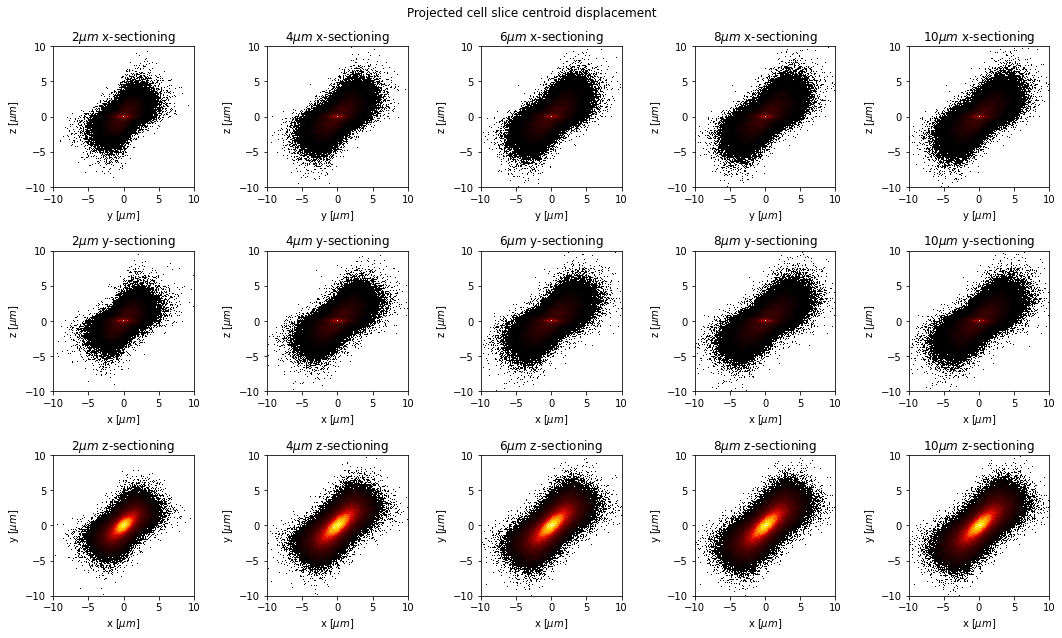

In [22]:
sectioning_axis_names = ("x", "y", "z")
fig, axes = plt.subplots(nrows=3, ncols=cell_slice_displacement_data["section_thickness_um"].nunique(), figsize=(15, 9))
for (i, row_axes), sectioning_axis_name in zip(enumerate(axes), sectioning_axis_names):
    x, y = tuple(a for a in sectioning_axis_names if a != sectioning_axis_name)
    df = cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == sectioning_axis_name]
    for (j, ax), (section_thickness_um, g) in zip(enumerate(row_axes), df.groupby("section_thickness_um")):
        dsshow(g, ds.Point(f"proj_cell_slice_centroid_displacement_{x}_um", f"proj_cell_slice_centroid_displacement_{y}_um"), cmap=cc.fire, ax=ax)
        ax.set_title(f"${section_thickness_um:g} \\mu m$ {sectioning_axis_name}-sectioning")
        ax.set_xlabel(f"{x} [$\\mu m$]")
        ax.set_ylabel(f"{y} [$\\mu m$]")
        ax.set_ylim(-10, 10)
        ax.set_xlim(-10, 10)
plt.suptitle("Projected cell slice centroid displacement")
plt.tight_layout()
plt.show()

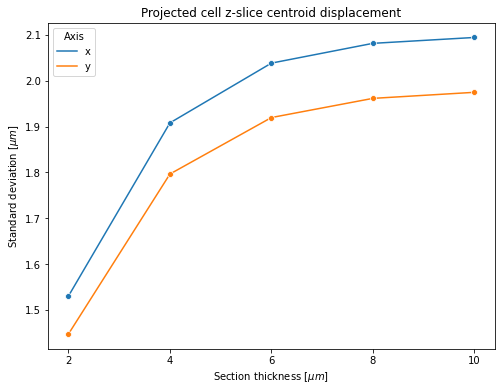

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

p = sns.lineplot(
    data=cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].melt(
        id_vars=["sectioning_axis", "sectioning_axis_name", "section_thickness_um", "section_offset_um", "cell_id", "cell_slice_number"],
        value_vars=["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um"],
        var_name="proj_cell_slice_centroid_displacement_column",
        value_name="proj_cell_slice_centroid_displacement_um",
    ),
    x="section_thickness_um",
    y="proj_cell_slice_centroid_displacement_um",
    hue="proj_cell_slice_centroid_displacement_column",
    hue_order=["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um"],
    estimator=np.std,
    ci=None,
    ax=ax,
    marker="o",
)
p.legend_.set_title("Axis")
for text, label in zip(p.legend_.texts, ["x", "y"]):
    text.set_text(label)
ax.set_title("Projected cell z-slice centroid displacement")
ax.set_xlabel(r"Section thickness [$\mu m$]")
ax.set_ylabel(r"Standard deviation [$\mu m$]")
ax.set_xticks(cell_slice_displacement_data["section_thickness_um"].unique())

plt.show()

In [24]:
cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].groupby("section_thickness_um")[
    ["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um"]
].mean()

,proj_cell_slice_centroid_displacement_x_um,proj_cell_slice_centroid_displacement_y_um
section_thickness_um,,
2.0,0.003951,0.002069
4.0,0.009718,0.009762
6.0,0.012535,0.013689
8.0,0.011704,0.013476
10.0,0.011279,0.012555


In [25]:
cell_slice_displacement_data[cell_slice_displacement_data["sectioning_axis_name"] == "z"].groupby("section_thickness_um")[
    ["proj_cell_slice_centroid_displacement_x_um", "proj_cell_slice_centroid_displacement_y_um"]
].cov()

proj_cell_slice_centroid_displacement_x_um  \
section_thickness_um                                                                                          
2.0                  proj_cell_slice_centroid_displacement_x_um                                    2.342148   
                     proj_cell_slice_centroid_displacement_y_um                                    1.407179   
4.0                  proj_cell_slice_centroid_displacement_x_um                                    3.640267   
                     proj_cell_slice_centroid_displacement_y_um                                    2.411103   
6.0                  proj_cell_slice_centroid_displacement_x_um                                    4.154491   
                     proj_cell_slice_centroid_displacement_y_um                                    2.843746   
8.0                  proj_cell_slice_centroid_displacement_x_um                                    4.332122   
                     proj_cell_slice_centroid_displacement_y_um                                    3.000149   
10.0                 proj_cell_slice_centroid_displacement_x_um                                    4.385700   
                     proj_cell_slice_centroid_displacement_y_um                                    3.050652   

                                                                 proj_cell_slice_centroid_displacement_y_um  
section_thickness_um                                                                                         
2.0                  proj_cell_slice_centroid_displacement_x_um                                    1.407179  
                     proj_cell_slice_centroid_displacement_y_um                                    2.095484  
4.0                  proj_cell_slice_centroid_displacement_x_um                                    2.411103  
                     proj_cell_slice_centroid_displacement_y_um                                    3.227141  
6.0                  proj_cell_slice_centroid_displacement_x_um                                    2.843746  
                     proj_cell_slice_centroid_displacement_y_um                                    3.684698  
8.0                  proj_cell_slice_centroid_displacement_x_um                                    3.000149  
                     proj_cell_slice_centroid_displacement_y_um                                    3.846967  
10.0                 proj_cell_slice_centroid_displacement_x_um                                    3.050652  
                     proj_cell_slice_centroid_displacement_y_um                                    3.898974